In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


DATA_DIR = Path("../raw")


In [2]:
files = list(DATA_DIR.glob("*.csv.zst"))
print(files)

[WindowsPath('../raw/glbx-mdp3-20100606-20251222.ohlcv-1d.csv.zst')]


In [3]:
df = pd.read_csv(files[0])
df

,ts_event,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
0,2010-06-06T00:00:00.000000000Z,35,1,182065,78.5900,78.5900,78.5000,78.5000,12,CLM1
1,2010-06-06T00:00:00.000000000Z,35,1,203578,2.0208,2.0208,2.0208,2.0208,14,HOV0
2,2010-06-06T00:00:00.000000000Z,35,1,100056,1.9765,1.9796,1.9636,1.9796,26,RBU0
3,2010-06-06T00:00:00.000000000Z,35,1,50849,1.9810,1.9810,1.9655,1.9704,49,RBQ0
4,2010-06-06T00:00:00.000000000Z,35,1,118184,-0.1240,-0.1240,-0.1245,-0.1245,10,HON0-HOZ0
...,...,...,...,...,...,...,...,...,...,...
2508883,2025-12-22T00:00:00.000000000Z,35,1,42014969,-3.4000,-3.3900,-3.4000,-3.3900,6,CLJ6-BZK6
2508884,2025-12-22T00:00:00.000000000Z,35,1,22149,-1.3200,-0.7200,-1.3400,-0.7200,176,CLM6-CLZ7
2508885,2025-12-22T00:00:00.000000000Z,35,1,268836,-0.1839,-0.1839,-0.1858,-0.1858,6,RBF6-RBQ6
2508886,2025-12-22T00:00:00.000000000Z,35,1,42285853,-0.0050,-0.0050,-0.0054,-0.0054,3,HOM7-HON7


In [4]:
symbols = pd.DataFrame(df['symbol'].unique(), columns=['symbol'])
instrument_ids = pd.DataFrame(df['instrument_id'].unique(), columns=['instrument_id'])
symbols_and_ids = pd.merge(df[['symbol', 'instrument_id']].drop_duplicates(), symbols, on='symbol').sort_values(by='symbol').reset_index(drop=True)
symbols_and_ids

,symbol,instrument_id
0,BZ:BF F0-G0-H0,144542
1,BZ:BF F1-G1-H1,205811
2,BZ:BF F2-G2-H2,246390
3,BZ:BF F3-G3-H3,328263
4,BZ:BF F4-G4-H4,253351
...,...,...
21518,UD:NG: SA 0919987095,987095
21519,UD:NG: SA 0919987096,987096
21520,UD:NG: SA 2569368,2569368
21521,UD:NG: SA 2570059,2570059


In [5]:
month_codes = "FGHJKMNQUVXZ"
pattern = rf'^CL[{month_codes}]\d$'
cl = df[df['symbol'].str.match(pattern)].copy()
cl = cl.sort_values(by=['ts_event', 'symbol']).reset_index(drop=True)
cl[["ts_event", "symbol", "close", "volume"]]

,ts_event,symbol,close,volume
0,2010-06-06T00:00:00.000000000Z,CLH1,77.22,2
1,2010-06-06T00:00:00.000000000Z,CLM1,78.50,12
2,2010-06-06T00:00:00.000000000Z,CLN0,70.34,3489
3,2010-06-06T00:00:00.000000000Z,CLQ0,71.70,599
4,2010-06-06T00:00:00.000000000Z,CLU0,72.68,102
...,...,...,...,...
103862,2025-12-22T00:00:00.000000000Z,CLX6,57.44,25
103863,2025-12-22T00:00:00.000000000Z,CLZ6,57.36,5533
103864,2025-12-22T00:00:00.000000000Z,CLZ7,58.30,3572
103865,2025-12-22T00:00:00.000000000Z,CLZ8,59.71,334


In [6]:
rolled_raw = cl.loc[cl.groupby('ts_event')["volume"].idxmax()].reset_index(drop=True)[["ts_event", "symbol", "close", "volume"]]
rolled_raw[["ts_event", "symbol", "volume"]]


,ts_event,symbol,volume
0,2010-06-06T00:00:00.000000000Z,CLN0,3489
1,2010-06-07T00:00:00.000000000Z,CLN0,378985
2,2010-06-08T00:00:00.000000000Z,CLN0,381371
3,2010-06-09T00:00:00.000000000Z,CLN0,404640
4,2010-06-10T00:00:00.000000000Z,CLN0,384521
...,...,...,...
4821,2025-12-17T00:00:00.000000000Z,CLG6,184944
4822,2025-12-18T00:00:00.000000000Z,CLG6,133164
4823,2025-12-19T00:00:00.000000000Z,CLG6,130793
4824,2025-12-21T00:00:00.000000000Z,CLG6,3270


In [7]:
mask = pd.DataFrame()
mask["flicker"] = (rolled_raw["symbol"] != rolled_raw["symbol"].shift(1)) & (rolled_raw["symbol"] != rolled_raw["symbol"].shift(-1))
mask["switch"] = (rolled_raw["symbol"] != rolled_raw["symbol"].shift(-1)) #| (rolled_raw["symbol"] != rolled_raw["symbol"].shift(-1))
mask.iat[-1,1] = False
mask



,flicker,switch
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
4821,False,False
4822,False,False
4823,False,False
4824,False,False


In [8]:
mask[mask["switch"]].index

Index([  10,   35,   62,   88,  114,  140,  166,  192,  218,  243,
       ...
       4636, 4662, 4690, 4715, 4743, 4767, 4793, 4794, 4795, 4819],
      dtype='int64', length=193)

In [9]:
for i in mask[mask["flicker"]].index:
    rolled_raw.loc[i] = cl.loc[cl["ts_event"] == rolled_raw.loc[i, "ts_event"]].nlargest(2, "volume").iloc[1]
rolled_raw[["ts_event", "symbol", "volume", "close"]]


,ts_event,symbol,volume,close
0,2010-06-06T00:00:00.000000000Z,CLN0,3489,70.34
1,2010-06-07T00:00:00.000000000Z,CLN0,378985,70.99
2,2010-06-08T00:00:00.000000000Z,CLN0,381371,72.37
3,2010-06-09T00:00:00.000000000Z,CLN0,404640,73.99
4,2010-06-10T00:00:00.000000000Z,CLN0,384521,75.58
...,...,...,...,...
4821,2025-12-17T00:00:00.000000000Z,CLG6,184944,56.73
4822,2025-12-18T00:00:00.000000000Z,CLG6,133164,55.85
4823,2025-12-19T00:00:00.000000000Z,CLG6,130793,56.54
4824,2025-12-21T00:00:00.000000000Z,CLG6,3270,56.87


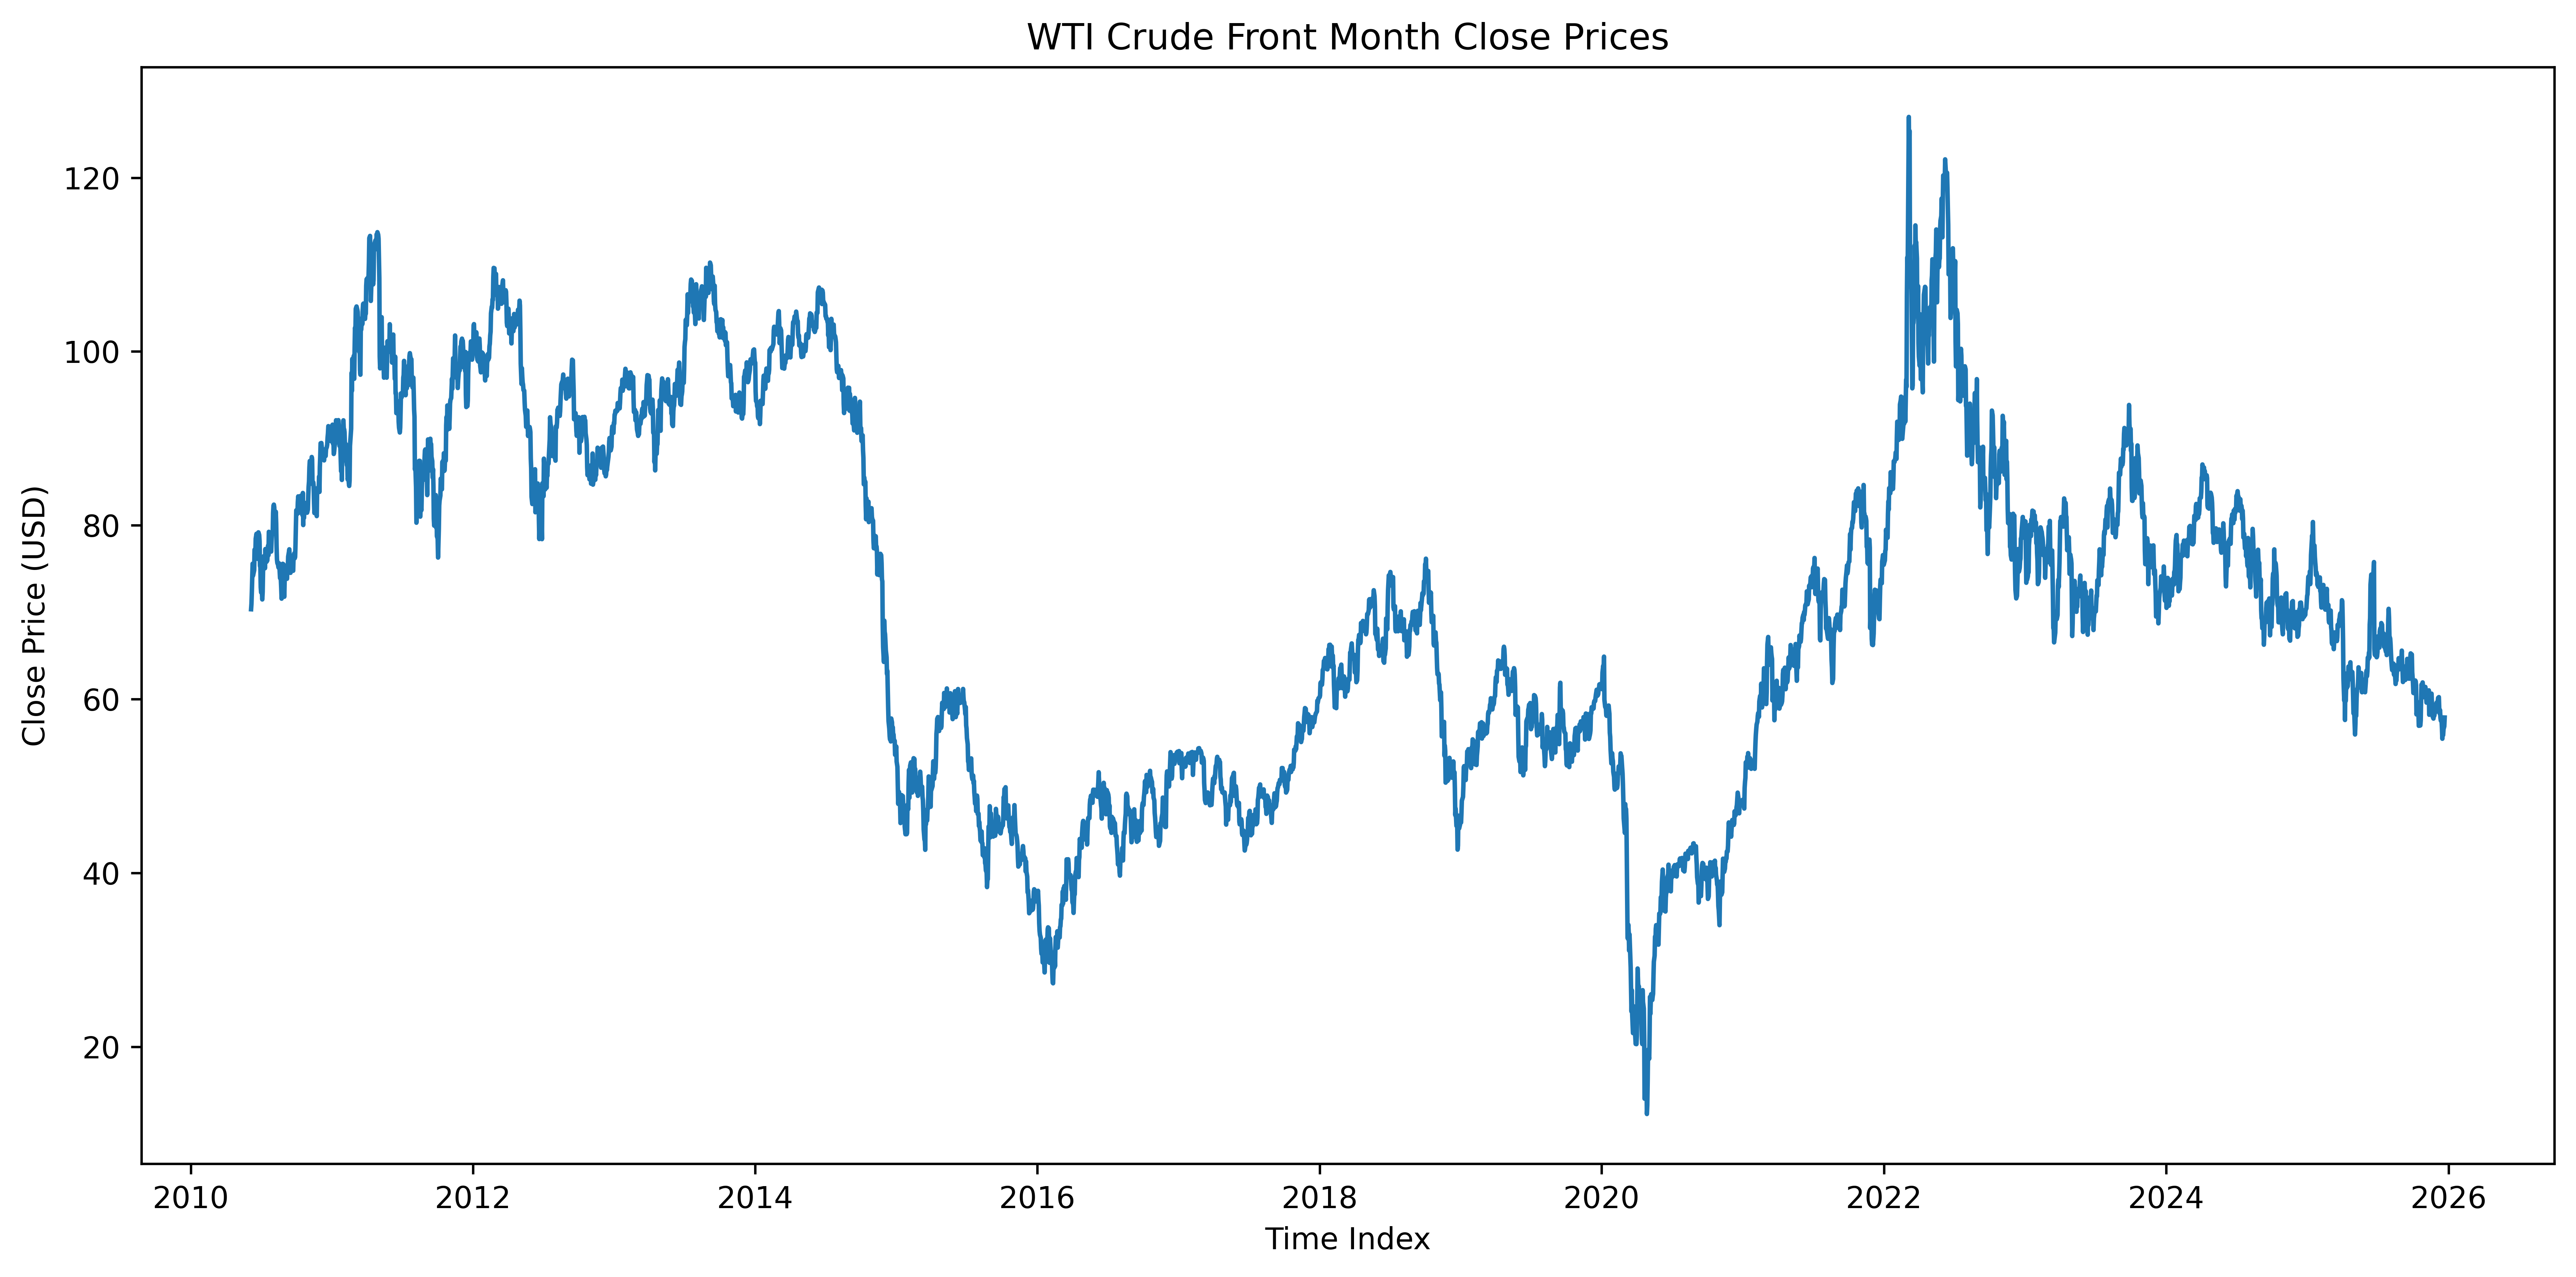

In [10]:
plt.plot(pd.to_datetime(rolled_raw['ts_event']), rolled_raw['close'], label='CL Front Month Close Prices')
plt.title('WTI Crude Front Month Close Prices')
plt.xlabel('Time Index')
plt.ylabel('Close Price (USD)')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.set_dpi(600)
plt.tight_layout()
plt.show()

In [11]:
panama_rolled = rolled_raw.copy()
panama_rolled

,ts_event,symbol,close,volume
0,2010-06-06T00:00:00.000000000Z,CLN0,70.34,3489
1,2010-06-07T00:00:00.000000000Z,CLN0,70.99,378985
2,2010-06-08T00:00:00.000000000Z,CLN0,72.37,381371
3,2010-06-09T00:00:00.000000000Z,CLN0,73.99,404640
4,2010-06-10T00:00:00.000000000Z,CLN0,75.58,384521
...,...,...,...,...
4821,2025-12-17T00:00:00.000000000Z,CLG6,56.73,184944
4822,2025-12-18T00:00:00.000000000Z,CLG6,55.85,133164
4823,2025-12-19T00:00:00.000000000Z,CLG6,56.54,130793
4824,2025-12-21T00:00:00.000000000Z,CLG6,56.87,3270


In [12]:
panama_rolled = rolled_raw.copy()
for i in mask[mask["switch"]].index:
    panama_rolled.loc[:i, "close"] += (panama_rolled.iat[i+1, 2] - panama_rolled.iat[i, 2]).round(2) # type: ignore
panama_rolled["close"] = panama_rolled["close"].round(2)
panama_rolled

,ts_event,symbol,close,volume
0,2010-06-06T00:00:00.000000000Z,CLN0,77.95,3489
1,2010-06-07T00:00:00.000000000Z,CLN0,78.60,378985
2,2010-06-08T00:00:00.000000000Z,CLN0,79.98,381371
3,2010-06-09T00:00:00.000000000Z,CLN0,81.60,404640
4,2010-06-10T00:00:00.000000000Z,CLN0,83.19,384521
...,...,...,...,...
4821,2025-12-17T00:00:00.000000000Z,CLG6,56.73,184944
4822,2025-12-18T00:00:00.000000000Z,CLG6,55.85,133164
4823,2025-12-19T00:00:00.000000000Z,CLG6,56.54,130793
4824,2025-12-21T00:00:00.000000000Z,CLG6,56.87,3270


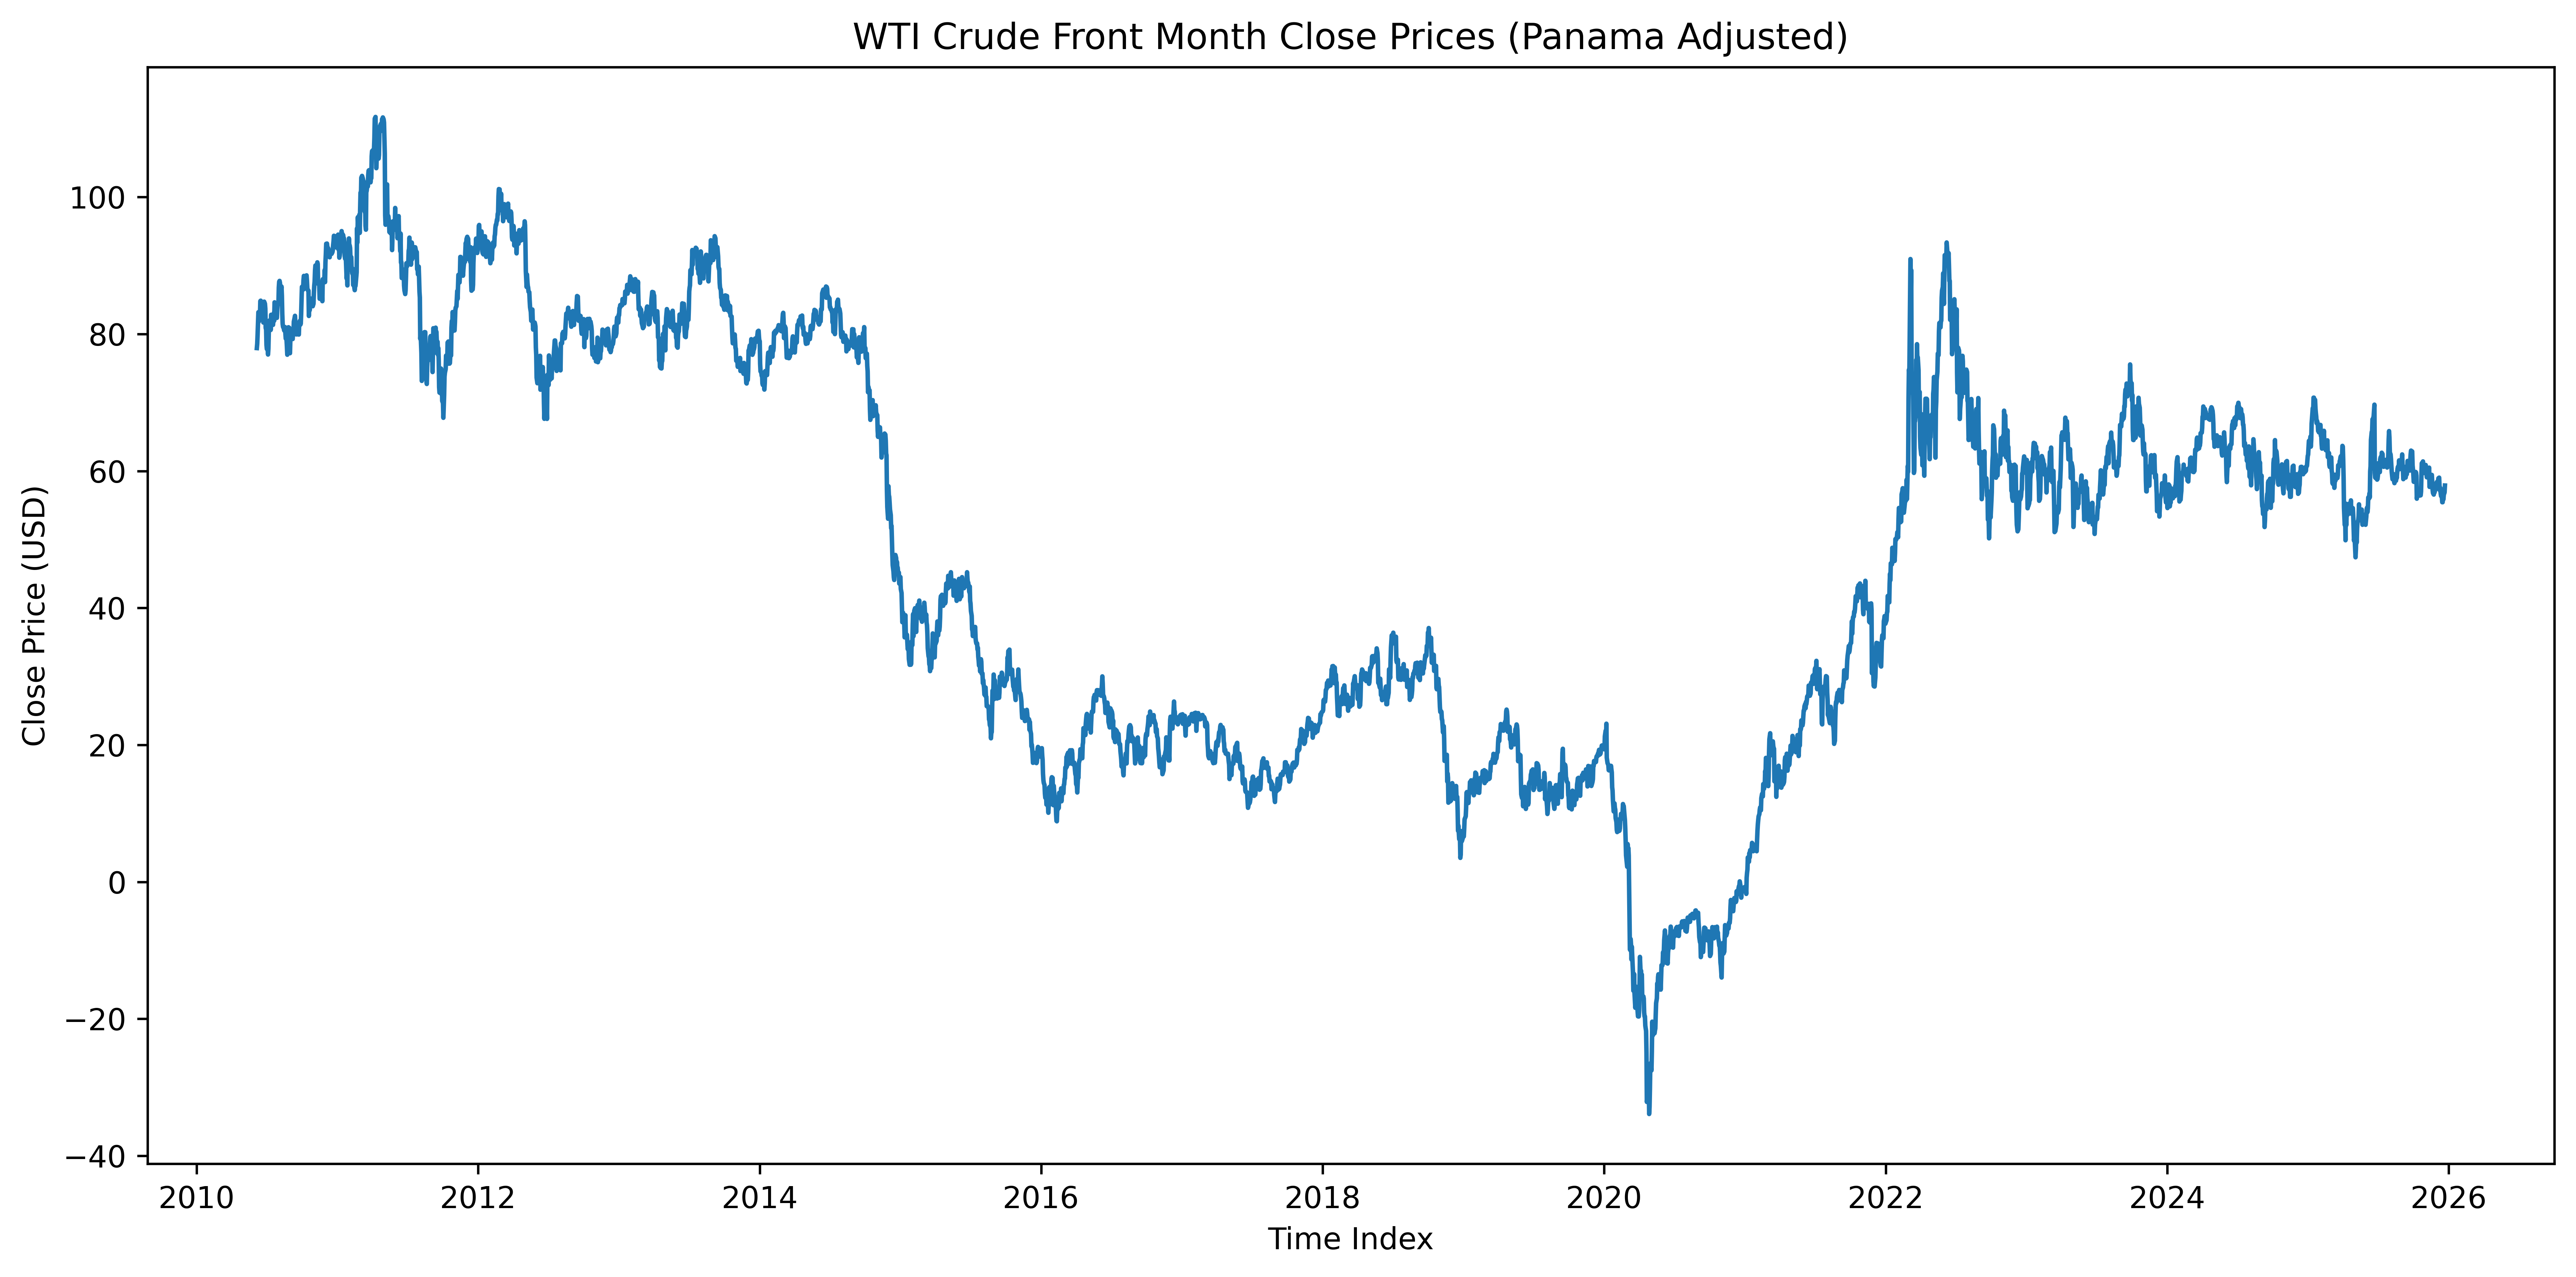

In [21]:
plt.plot(pd.to_datetime(panama_rolled['ts_event']), panama_rolled['close'], label='CL Front Month Close Prices (Panama Adjusted)')
plt.title('WTI Crude Front Month Close Prices (Panama Adjusted)')
plt.xlabel('Time Index')
plt.ylabel('Close Price (USD)')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.set_dpi(600)
plt.tight_layout()
plt.show()


In [17]:
panama_rolled.to_csv(DATA_DIR.parent / "processed" / "cl_front_month_panama_adjusted.csv", index=False)